# Import Library

# **Implementasi Metode RNN**
**Dataset :** Jakarta

**Kelompok :** 13 - PMA (B)

In [3]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras

# Load Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Jakarta 2015 - 2022.csv to Jakarta 2015 - 2022.csv


In [4]:
data = pd.read_csv('Jakarta 2015 - 2022.csv')
data_asli = data.copy()
data.head()

,datetime,total_visitor,total_accomodation
0,1/1/2014,193017,16332
1,2/1/2014,185851,17101
2,3/1/2014,204004,17438
3,4/1/2014,186373,17943
4,5/1/2014,190716,18123


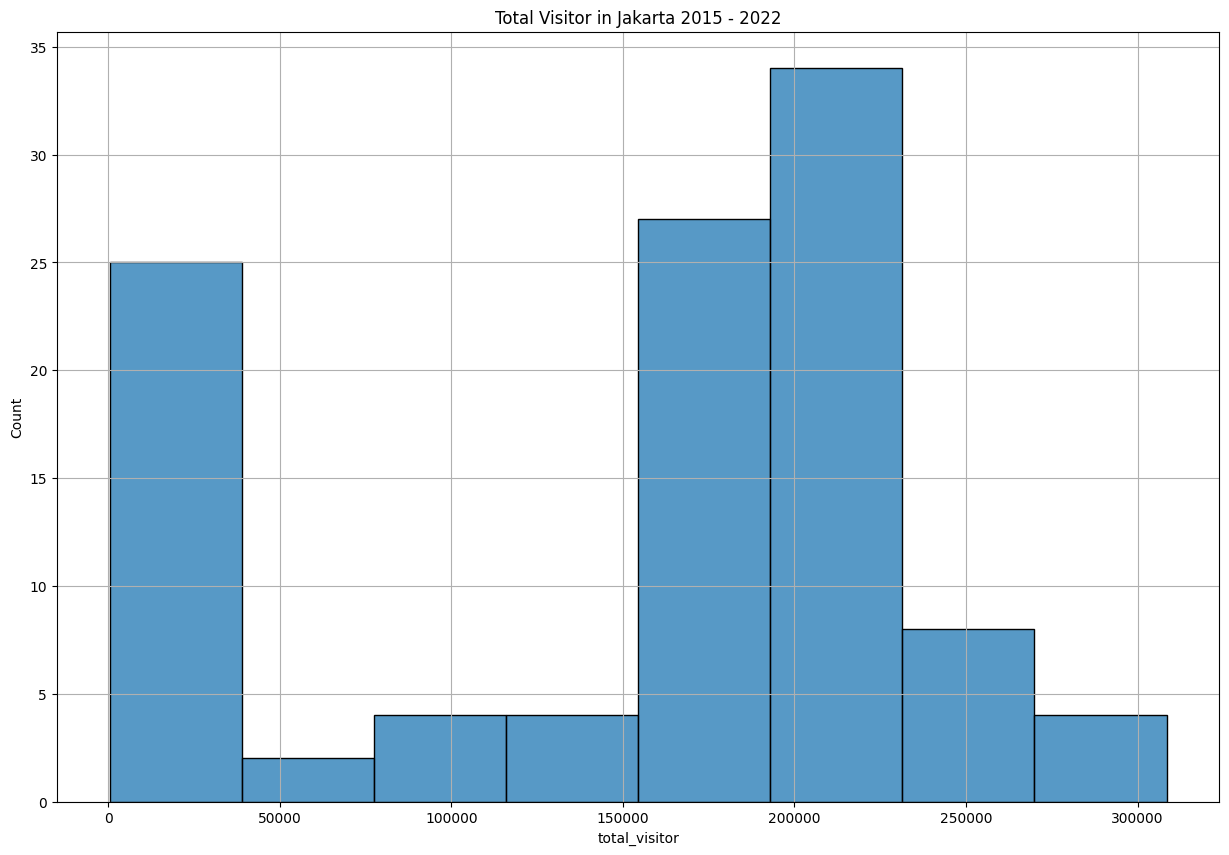

In [ ]:
# plot to see the total_visitor varience
plt.figure(figsize=(15, 10))
sns.histplot(data['total_visitor'], kde=False)
plt.title("Total Visitor in Jakarta 2015 - 2022")
plt.grid()
plt.show()

# Preprocessing Data

In [ ]:
# set data index as datetime column
train_datetime = pd.to_datetime(data.datetime)
data = data.set_index('datetime')
data.head()

,total_visitor,total_accomodation
datetime,,
1/1/2014,193017,16332
2/1/2014,185851,17101
3/1/2014,204004,17438
4/1/2014,186373,17943
5/1/2014,190716,18123


In [ ]:
input_col = list(data)[0:2]
print(input_col)

['total_visitor', 'total_accomodation']


In [ ]:
data_for_training = data[input_col].astype(float)

## Normalize Data

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(data_for_training)
scaled_data_train = scaler.transform(data_for_training)

# Scenario 1 (80% Train - 20% Test)

## Split data

In [ ]:
# Define sequence length and features
sequence_length = 12  # Data perbulan dalam satu tahun
num_features = len(data.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
trainX, testX, trainY, testY = train_test_split(sequences,labels, test_size=0.2)

print("Train X shape:", trainX.shape)
print("Train Y shape:", trainY.shape)
print("Test X shape:", testX.shape)
print("Test Y shape:", testY.shape)

Train X shape: (76, 12, 2)
Train Y shape: (76,)
Test X shape: (20, 12, 2)
Test Y shape: (20,)


## Train data

In [ ]:
#Create RNN Model
model = Sequential()
#Layer 1
model.add(SimpleRNN(64,activation="tanh",return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]))) # unit = 12,24,36,48 (bebas) # ^ train_X.shape[1] --> index pertama nya jadi = 20
model.add(Dropout(0.2))
#Layer 2
model.add(SimpleRNN(32,activation="tanh",return_sequences=True)) # activation = Relu, sigmoid, tanh, dicoba" sendiri
model.add(Dropout(0.2))
#layer 3
model.add(SimpleRNN(16,activation="tanh",return_sequences=False))
model.add(Dropout(0.2))
#Add Dense
model.add(Dense(1)) # menyesuaikan nilai output variabel kita yag mau di prediksi, utk RNN cocok utk 1 jadi klo mau 2 atau lebih bisa pakai yang metode lain
#Model Summary
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_111 (SimpleRNN)  (None, 12, 64)            4288      
                                                                 
 dropout_103 (Dropout)       (None, 12, 64)            0         
                                                                 
 simple_rnn_112 (SimpleRNN)  (None, 12, 32)            3104      
                                                                 
 dropout_104 (Dropout)       (None, 12, 32)            0         
                                                                 
 simple_rnn_113 (SimpleRNN)  (None, 16)                784       
                                                                 
 dropout_105 (Dropout)       (None, 16)                0         
                                                                 
 dense_37 (Dense)            (None, 1)               

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32,  verbose=1)

Epoch 1/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0880
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1040
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0735
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1034
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0798
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0795
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0808
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0553
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0728
Epoch 10/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0738
Epoch 11/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0836
Epoch 12/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0686
Epoch 13/100
3/3 [==============================]

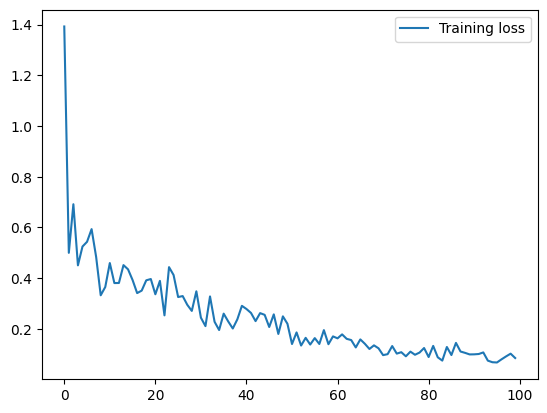

In [ ]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training loss')
plt.legend()

## Predict vs Actual

In [ ]:
predictions = model.predict(testX)
score = r2_score(testY,predictions)
print("R-Squared Score of RNN model",score)

In [ ]:
def plotting_actual_vs_pred(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized scale')
    plt.legend()
    plt.show()

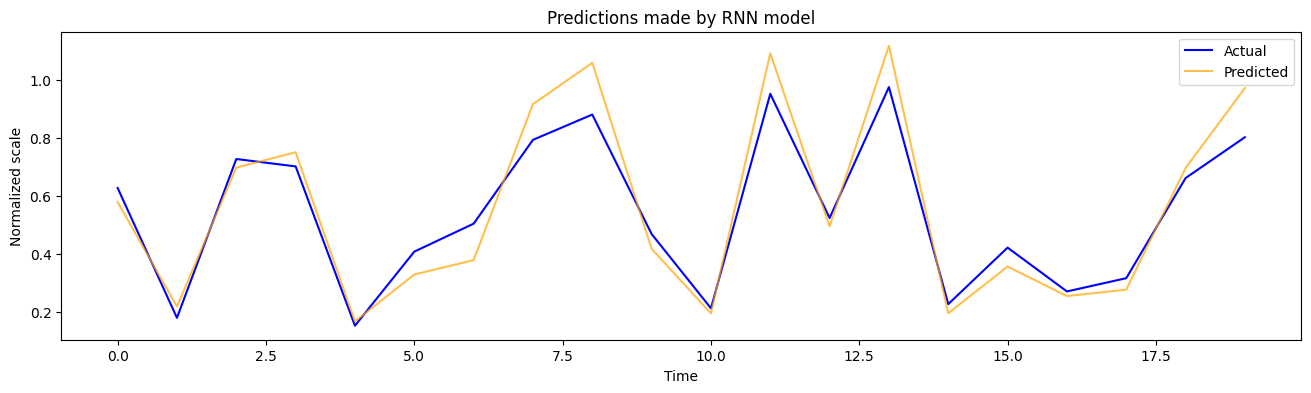

In [ ]:
plotting_actual_vs_pred(testY, predictions, "Predictions made by RNN model")

## Forecast

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
predictions = model.predict(trainX[-n_month_for_prediction:])
mse = mean_squared_error(trainY[-n_month_for_prediction:], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(trainY[-n_month_for_prediction:], predictions)
mae = mean_absolute_error(trainY[-n_month_for_prediction:], predictions)
mape = mean_absolute_percentage_error(trainY[-n_month_for_prediction:], predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)
print("MAE:", mae)
print("MAPE:", mape)

1/1 [==============================] - 0s 21ms/step
MSE: 0.011227888792008867
RMSE: 0.10596173267745704
R2: 0.8836766158575458
MAE: 0.07387949977318513
MAPE: 0.12147994076566926


In [ ]:
prediction_copies = np.repeat(predictions, data_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

<ipython-input-436-c9f9adf60240>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['datetime'] = pd.to_datetime(original['datetime'])


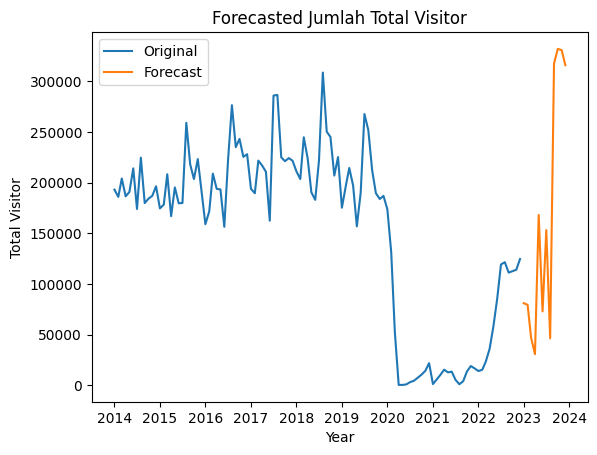

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │      81017.5 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │      79423.7 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      46790.2 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │      30761.4 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     167981   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │      72907.7 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     153106   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      46364.3 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     317309   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     331750   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     330615   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates = []

for time_i in predict_period_month:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date': forecast_dates, 'total_visitor': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original = data_asli[['datetime', 'total_visitor']]
original['datetime'] = pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2013-01-01']

sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Jumlah Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred_future))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

# Scenario 2 (70% Train - 30% Test)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ivana27lita/kumpulan-dataset/master/Jakarta%202015%20-%202022.csv')
data_asli = data.copy()
data.head()

,datetime,total_visitor,total_accomodation
0,1/1/2014,193017,16332
1,2/1/2014,185851,17101
2,3/1/2014,204004,17438
3,4/1/2014,186373,17943
4,5/1/2014,190716,18123


## Split data

In [ ]:
# Define sequence length and features
sequence_length = 12  # Karena data terdiri dari data perbulan dalam satu tahun
num_features = len(data.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
trainX2, testX2, trainY2, testY2 = train_test_split(sequences,labels, test_size=0.3)

print("Train X shape:", trainX2.shape)
print("Train Y shape:", trainY2.shape)
print("Test X shape:", testX2.shape)
print("Test Y shape:", testY2.shape)

Train X shape: (67, 12, 2)
Train Y shape: (67,)
Test X shape: (29, 12, 2)
Test Y shape: (29,)


## Train data

In [ ]:
model2 = Sequential()
model2.add(SimpleRNN(64,activation="tanh",return_sequences=True, input_shape=(trainX2.shape[1],trainX2.shape[2]))) # unit = 12,24,36,48 (bebas)
# ^ train_X.shape[1] --> index pertama nya jadi = 20
model2.add(Dropout(0.2))
model2.add(SimpleRNN(32,activation="tanh",return_sequences=True)) # activation = Relu, sigmoid, tanh, dicoba" sendiri
model2.add(Dropout(0.2))
model2.add(SimpleRNN(16,activation="tanh",return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1)) # menyesuaikan nilai output variabel kita yag mau di prediksi, utk RNN cocok utk 1 jadi klo mau 2 atau lebih bisa pakai yang metode lain
model2.summary()
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_114 (SimpleRNN)  (None, 12, 64)            4288      
                                                                 
 dropout_106 (Dropout)       (None, 12, 64)            0         
                                                                 
 simple_rnn_115 (SimpleRNN)  (None, 12, 32)            3104      
                                                                 
 dropout_107 (Dropout)       (None, 12, 32)            0         
                                                                 
 simple_rnn_116 (SimpleRNN)  (None, 16)                784       
                                                                 
 dropout_108 (Dropout)       (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 1)               

In [ ]:
history2 = model2.fit(trainX2, trainY2, epochs=100, batch_size=32,  verbose=1)

Epoch 1/100
3/3 [==============================] - 3s 18ms/step - loss: 0.3584
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.5433
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.3650
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.4313
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3332
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.3144
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3121
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.3569
Epoch 9/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2892
Epoch 10/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2645
Epoch 11/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2289
Epoch 12/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3549
Epoch 13/100
3/3 [==============================]

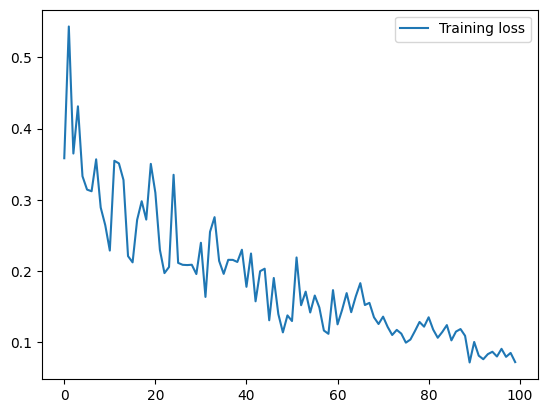

In [ ]:
# Plot the training loss
plt.plot(history2.history['loss'], label='Training loss')
plt.legend()

## Predict vs Actual

In [ ]:
predictions2 = model2.predict(testX2)
score2 = r2_score(testY2,predictions2)
print("R-Squared Score of RNN model",score2)

1/1 [==============================] - 0s 322ms/step
R-Squared Score of RNN model 0.9213963125373626


In [ ]:
def plotting_actual_vs_pred2(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized scale')
    plt.legend()
    plt.show()

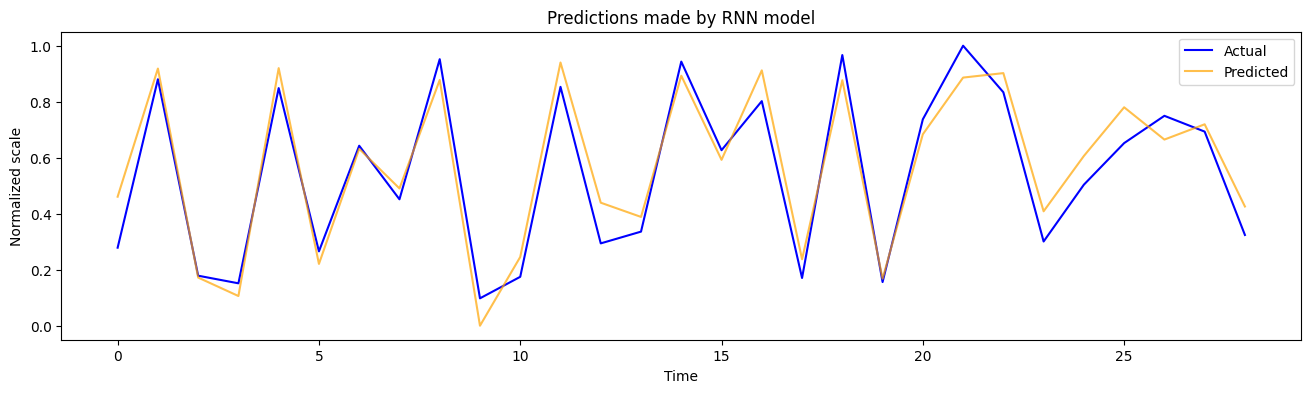

In [ ]:
plotting_actual_vs_pred2(testY2, predictions2, "Predictions made by RNN model")

## Forecast

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
predictions2 = model2.predict(trainX2[-n_month_for_prediction:])
mse2 = mean_squared_error(trainY2[-n_month_for_prediction:], predictions2)
rmse2 = np.sqrt(mse2)
r22 = r2_score(trainY2[-n_month_for_prediction:], predictions2)
mae2 = mean_absolute_error(trainY2[-n_month_for_prediction:], predictions2)
mape2 = mean_absolute_percentage_error(trainY2[-n_month_for_prediction:], predictions2)

print("MSE:", mse2)
print("RMSE:", rmse2)
print("R2:", r22)
print("MAE:", mae2)
print("MAPE:", mape2)

1/1 [==============================] - 0s 21ms/step
MSE: 0.00372106303577481
RMSE: 0.06100051668449055
R2: 0.9327812730433724
MAE: 0.05168991490009441
MAPE: 0.10070545118199765


In [ ]:
prediction_copies2 = np.repeat(predictions2, data_for_training.shape[1], axis=-1)
y_pred_future2 = scaler.inverse_transform(prediction_copies2)[:,0]

<ipython-input-448-04bdad42764e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original2['datetime'] = pd.to_datetime(original2['datetime'])


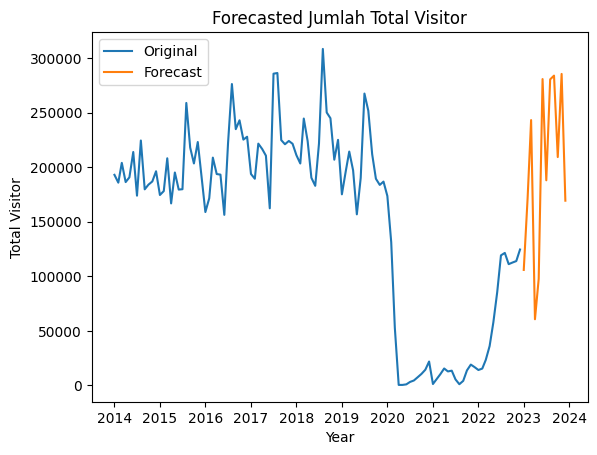

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     105832   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     171699   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     243213   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │      60627.4 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      97689   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     280809   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     188009   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     280528   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     283964   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     209303   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     285520   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates2 = []

for time_i in predict_period_month:
    forecast_dates2.append(time_i.date())

df_forecast2 = pd.DataFrame({'Date': forecast_dates2, 'total_visitor': y_pred_future2})
df_forecast2['Date'] = pd.to_datetime(df_forecast2['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original2 = data_asli[['datetime', 'total_visitor']]
original2['datetime'] = pd.to_datetime(original2['datetime'])
original2 = original2.loc[original2['datetime'] >= '2014-01-01']

sns.lineplot(data=original2, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast2, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Jumlah Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_2 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_2, y_pred_future2))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

# Scenario 3 (60% Train - 40% Test)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ivana27lita/kumpulan-dataset/master/Jakarta%202015%20-%202022.csv')
data_asli = data.copy()
data.head()

,datetime,total_visitor,total_accomodation
0,1/1/2014,193017,16332
1,2/1/2014,185851,17101
2,3/1/2014,204004,17438
3,4/1/2014,186373,17943
4,5/1/2014,190716,18123


## Split data

In [ ]:
# Define sequence length and features
sequence_length = 12  # Karena data terdiri dari data perbulan dalam satu tahun
num_features = len(data.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data_train) - sequence_length):
    seq = scaled_data_train[i:i+sequence_length]
    label = scaled_data_train[i+sequence_length][1]
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
trainX3, testX3, trainY3, testY3 = train_test_split(sequences,labels, test_size=0.4)

print("Train X shape:", trainX3.shape)
print("Train Y shape:", trainY3.shape)
print("Test X shape:", testX3.shape)
print("Test Y shape:", testY3.shape)

Train X shape: (57, 12, 2)
Train Y shape: (57,)
Test X shape: (39, 12, 2)
Test Y shape: (39,)


## Train data

In [ ]:
model3 = Sequential()
model3.add(SimpleRNN(64,activation="tanh",return_sequences=True, input_shape=(trainX3.shape[1],trainX3.shape[2]))) # unit = 12,24,36,48 (bebas)
# ^ train_X.shape[1] --> index pertama nya jadi = 20
model3.add(Dropout(0.2))
model3.add(SimpleRNN(32,activation="tanh",return_sequences=True)) # activation = Relu, sigmoid, tanh, dicoba" sendiri
model3.add(Dropout(0.2))
model3.add(SimpleRNN(16,activation="tanh",return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(1)) # menyesuaikan nilai output variabel kita yag mau di prediksi, utk RNN cocok utk 1 jadi klo mau 2 atau lebih bisa pakai yang metode lain
model3.summary()
# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_117 (SimpleRNN)  (None, 12, 64)            4288      
                                                                 
 dropout_109 (Dropout)       (None, 12, 64)            0         
                                                                 
 simple_rnn_118 (SimpleRNN)  (None, 12, 32)            3104      
                                                                 
 dropout_110 (Dropout)       (None, 12, 32)            0         
                                                                 
 simple_rnn_119 (SimpleRNN)  (None, 16)                784       
                                                                 
 dropout_111 (Dropout)       (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 1)               

In [ ]:
history3 = model3.fit(trainX3, trainY3, epochs=100, batch_size=32,  verbose=1)

Epoch 1/100
2/2 [==============================] - 3s 23ms/step - loss: 1.0893
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 0.9599
Epoch 3/100
2/2 [==============================] - 0s 20ms/step - loss: 0.5689
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 0.6512
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6791
Epoch 6/100
2/2 [==============================] - 0s 22ms/step - loss: 0.4485
Epoch 7/100
2/2 [==============================] - 0s 20ms/step - loss: 0.5487
Epoch 8/100
2/2 [==============================] - 0s 18ms/step - loss: 0.9777
Epoch 9/100
2/2 [==============================] - 0s 19ms/step - loss: 0.4625
Epoch 10/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5274
Epoch 11/100
2/2 [==============================] - 0s 18ms/step - loss: 0.5983
Epoch 12/100
2/2 [==============================] - 0s 22ms/step - loss: 0.4639
Epoch 13/100
2/2 [==============================]

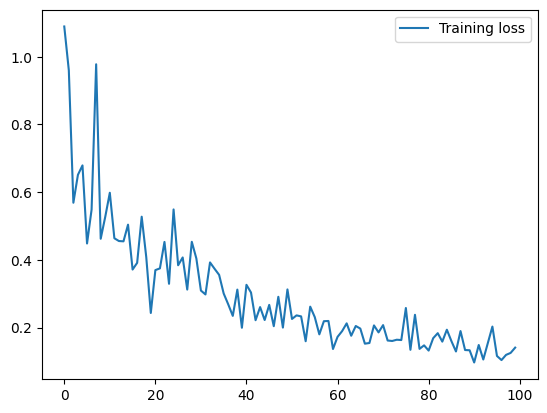

In [ ]:
# Plot the training loss
plt.plot(history3.history['loss'], label='Training loss')
plt.legend()

## Predict vs Actual

In [ ]:
predictions3 = model3.predict(testX3)
score3 = r2_score(testY3,predictions3)
print("R-Squared Score of RNN model",score3)

2/2 [==============================] - 0s 8ms/step
R-Squared Score of RNN model 0.680543034860701


In [ ]:
def plotting_actual_vs_pred3(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized scale')
    plt.legend()
    plt.show()

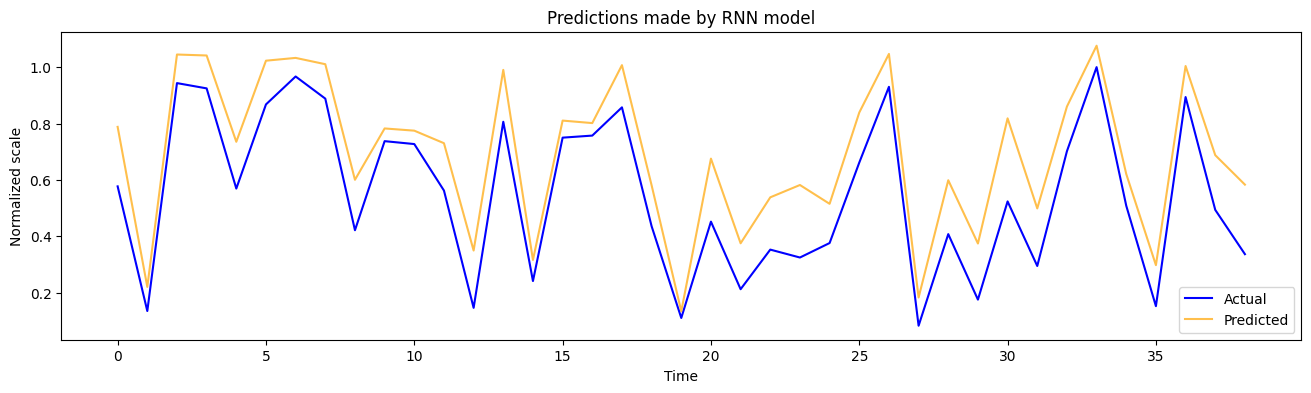

In [ ]:
plotting_actual_vs_pred3(testY3, predictions3, "Predictions made by RNN model")

## Forecast

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(train_datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Print the error metrics
predictions3 = model3.predict(trainX3[-n_month_for_prediction:])
mse3 = mean_squared_error(trainY3[-n_month_for_prediction:], predictions3)
rmse3 = np.sqrt(mse3)
r23 = r2_score(trainY3[-n_month_for_prediction:], predictions3)
mae3 = mean_absolute_error(trainY3[-n_month_for_prediction:], predictions3)
mape3 = mean_absolute_percentage_error(trainY3[-n_month_for_prediction:], predictions3)

print("MSE:", mse3)
print("RMSE:", rmse3)
print("R2:", r23)
print("MAE:", mae3)
print("MAPE:", mape3)

1/1 [==============================] - 0s 21ms/step
MSE: 0.03842787888730657
RMSE: 0.1960303009417334
R2: 0.2607117856956198
MAE: 0.18645483576365152
MAPE: 0.4931004606623137


In [ ]:
prediction_copies3 = np.repeat(predictions3, data_for_training.shape[1], axis=-1)
y_pred_future3 = scaler.inverse_transform(prediction_copies3)[:,0]

<ipython-input-460-72c6867ad5ae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original3['datetime'] = pd.to_datetime(original3['datetime'])


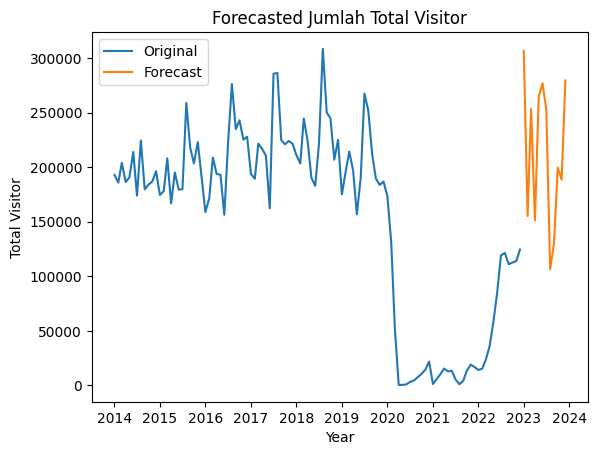

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       306593 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       155281 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       253331 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       151375 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       264775 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       277034 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       252395 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       106597 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       130570 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       199645 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       188532 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates3 = []

for time_i in predict_period_month:
    forecast_dates3.append(time_i.date())

df_forecast3 = pd.DataFrame({'Date': forecast_dates3, 'total_visitor': y_pred_future3})
df_forecast3['Date'] = pd.to_datetime(df_forecast3['Date'])

# Assuming 'original' contains the original data with 'datetime' and 'total_visitor' columns
original3 = data_asli[['datetime', 'total_visitor']]
original3['datetime'] = pd.to_datetime(original3['datetime'])
original3 = original3.loc[original3['datetime'] >= '2014-01-01']

sns.lineplot(data=original3, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast3, x='Date', y='total_visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Jumlah Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred_future3))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table)

# Conclusion

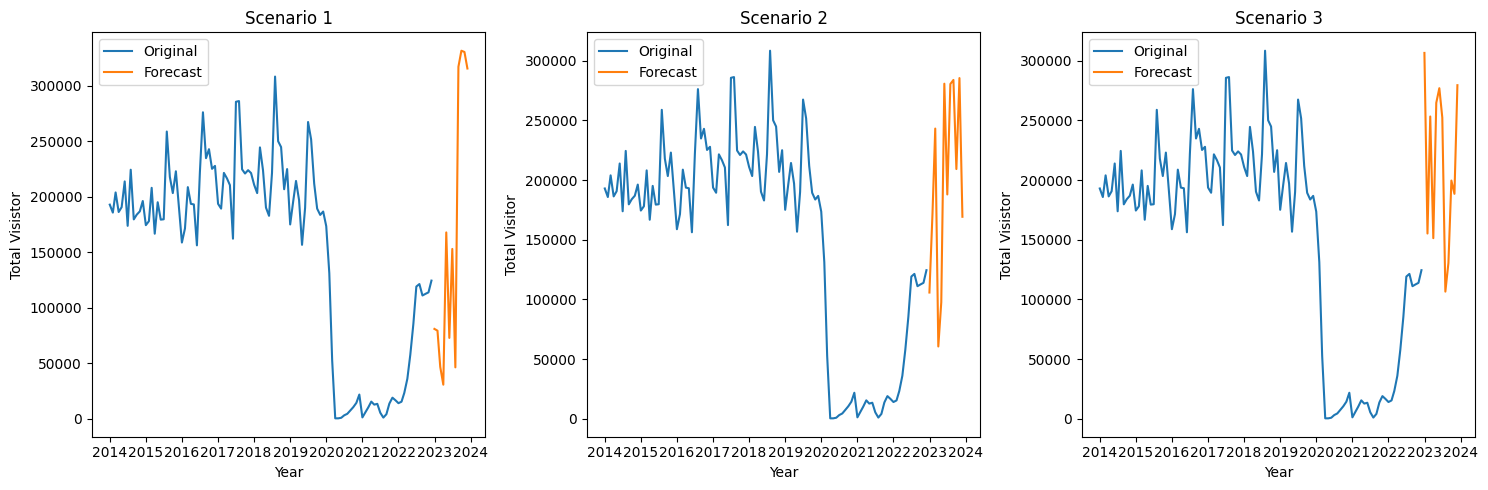

╒════════════╤═════════╤════════════╤══════════╤═══════════╤═══════════╤══════════╕
│ Scenario   │ Model   │        MSE │     MAPE │       MAE │      RMSE │       R2 │
╞════════════╪═════════╪════════════╪══════════╪═══════════╪═══════════╪══════════╡
│ Scenario 1 │ RNN     │ 0.0112279  │ 0.12148  │ 0.0738795 │ 0.105962  │ 0.883677 │
├────────────┼─────────┼────────────┼──────────┼───────────┼───────────┼──────────┤
│ Scenario 2 │ RNN     │ 0.00372106 │ 0.100705 │ 0.0516899 │ 0.0610005 │ 0.932781 │
├────────────┼─────────┼────────────┼──────────┼───────────┼───────────┼──────────┤
│ Scenario 3 │ RNN     │ 0.0384279  │ 0.4931   │ 0.186455  │ 0.19603   │ 0.260712 │
╘════════════╧═════════╧════════════╧══════════╧═══════════╧═══════════╧══════════╛


In [ ]:
plt.figure(figsize=(15, 5))

# Scenario 1
plt.subplot(1, 3, 1)
sns.lineplot(data=original, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visistor')
plt.title('Scenario 1')
plt.legend()

# Scenario 2
plt.subplot(1, 3, 2)
sns.lineplot(data=original2, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast2, x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Scenario 2')
plt.legend()

# Scenario 3
plt.subplot(1, 3, 3)
sns.lineplot(data=original3, x='datetime', y='total_visitor', label='Original')
sns.lineplot(data=df_forecast3 , x='Date', y='total_visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visistor')
plt.title('Scenario 3')
plt.legend()

plt.tight_layout()
plt.show()

# Define the data for each scenario
scenario_data = [
    {
        'Scenario': 'Scenario 1',
        'Model': 'RNN',
        'MSE': mse,
        'MAPE': mape,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    },
    {
        'Scenario': 'Scenario 2',
        'Model': 'RNN',
        'MSE': mse2,
        'MAPE': mape2,
        'MAE': mae2,
        'RMSE': rmse2,
        'R2': r22
    },
    {
        'Scenario': 'Scenario 3',
        'Model': 'RNN',
        'MSE': mse3,
        'MAPE': mape3,
        'MAE': mae3,
        'RMSE': rmse3,
        'R2': r23
    }
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(scenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
table4 = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table4)
